# DSA-2000 Data
## Estimating sizes, rates, and costs for CDR and PDR
## Casey Law, claw@astro.caltech.edu

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import healpy

## Define some useful functions


In [2]:
resolution = lambda freq, bmax: 1.22*3600*np.degrees(3e8/float(freq)/bmax) # resolution in asec for freq in Hz, bmax in meters
sensitivity = lambda sefd, dt, bw, eta, nbl: sefd/(eta*np.sqrt(nbl*2 * dt * bw * 2))    # sefd in Jy, dt in s, bw in Hz, assumes std correlator eficiency and 2 pols
tobs = lambda s0, sefd, na, bw, eta: (sefd/(s0*eta))**2/(na*(na-1)*bw*2)    # obsering time in s (inverse of sensitivity eqn)
area_field = lambda fov: 0.5665 * fov**2  # fov in amin
surveyspeed = lambda fov, t0: area_field(fov)/t0         # ss in deg2/hr, fov in amin, t0 is time per pointing in s
f_beam = lambda rad, fwhm: np.exp(-4*np.log(2)*(rad/fwhm)**2)  # beam function (fractional power at radius rad)

datarate_vis = lambda na, nch, npol, tsamp: (na*(na-1)/2)*nch*npol*8/tsamp/1024**2  # MB/s for tsamp in s

In [3]:
surveytime = lambda band, sensitivity, area, overhead: overhead * area/surveyspeed(fov[band], tobs(sensitivity, sefd[band], na[band], bw_max[band], eta[band]))   # total time in hours for given band, area in sq deg and sensitivity in Jy

# Effective survey speed for extragalactic specs (alpha = -0.7, gamma => euclidean).
ess_eg = lambda fov, dt, nu, sensitivity: ess_nuflux(fov, dt, nu, -0.7, sensitivity, -1.5)
sigma_confusion = lambda nu, theta: 1.2e-6*(nu/3.02e9)**(-0.7)*(theta/8)**(10/3)  # confusion with freq in Hz, theta in asec (Condon et al 2012)
survey_area = lambda dec_lim: (1+np.sin(np.radians(np.abs(dec_lim))))*(2*np.pi*(180/np.pi)**2)  # sq deg, exclude outside dec_lim

In [4]:
def find_hpnside(size, verbose=False):
    """ Use healpix scheme to find optimal nsize for a given size in degrees
    """
    for i in range(20):
        resol = np.degrees(healpy.nside2resol(2**i))
        if resol < size:
            if verbose:
                print(f'nside=2**{i} has resolution of {resol:1.1e} deg (resolves limit of {size} deg)')
            break
    return 2**i

## Set telescope parameters as a function of band/config

In [5]:
# keys defined for configurations and bands separately.
names = ['DSA', 'VLA', 'ASKAP']
na = {'DSA': 2000, 'VLA': 27, 'ASKAP': 36}   # number of antennas
freq = {'DSA': 1.35e9, 'VLA': 3.0e9, 'ASKAP': 1.28e9}  # band center
fov = {'DSA': 60*3.06, 'VLA': 15., 'ASKAP': 60*3.}    # fwhm field of view (theta_pb) in arcminutes  # use Condon et al
bw_max = {'DSA': 0.65*1.3e9, 'VLA': 1.5e9, 'ASKAP': 288e6}    # bandwidth (minus RFI)
bmax = {'DSA': 17e3, 'VLAB': 11.1e3, 'ASKAP': 6e3}    # longest baselines in meter
sefd = {'DSA': 5020, 'VLA': 370, 'ASKAP': 1952}    # array SEFD
# VLA sefd values appear high, because we assume 27 ants, whereas exposure calculator uses 25 ants. result is the same in both cases.
eta = {'DSA': 1.0, 'VLA': 0.92, 'ASKAP': 1.0}   # correlator efficiency
surveyspecs = {'DSA All-Sky': [3e4, 2.04e-6, 1.25, 1.0],
               'VLASS': [3.3885e4, 122e-6, 1.17, 1.09],
               'ASKAP EMU': [3.0939e4, 10e-6, 1.25, 1.0]}  # something must be wrong with ASKAP numbers

In [6]:
blfrac = np.array([   2713.,    4985.,    9054.,   15119.,   22950.,   32325.,
          43181.,   55824.,   69858.,   85469.,  102308.,  120628.,
         140305.,  161417.,  183853.,  207582.,  231966.,  258083.,
         285248.,  313273.,  342334.,  372247.,  403392.,  435111.,
         468076.,  501321.,  535350.,  570064.,  605587.,  641260.,
         677628.,  714315.,  751568.,  788970.,  826299.,  863931.,
         901520.,  939318.,  977137., 1014510., 1051771., 1088905.,
        1126009., 1162462., 1198652., 1234562., 1269596., 1304725.,
        1338824., 1372722., 1405761., 1438268., 1469989., 1501154.,
        1531615., 1561165., 1589887., 1617913., 1645118., 1670979.,
        1696439., 1720885., 1744597., 1767487., 1789383., 1810425.,
        1830348., 1849484., 1867862., 1885488., 1902348., 1918459.,
        1933525., 1947866., 1961529., 1974579., 1986612., 1998076.,
        2009133., 2019197., 2028535., 2037223., 2045349., 2052889.,
        2059729., 2065997., 2071635., 2076675., 2081213., 2085130.,
        2088597., 2091336., 2093612., 2095354., 2096617., 2097443.,
        2097907., 2098089., 2098162., 2098176.])/2098176
minbl = np.array([    153.93621821,   307.87243643,   461.80865464,
          615.74487286,   769.68109107,   923.61730929,  1077.5535275 ,
         1231.48974571,  1385.42596393,  1539.36218214,  1693.29840036,
         1847.23461857,  2001.17083679,  2155.107055  ,  2309.04327322,
         2462.97949143,  2616.91570964,  2770.85192786,  2924.78814607,
         3078.72436429,  3232.6605825 ,  3386.59680072,  3540.53301893,
         3694.46923714,  3848.40545536,  4002.34167357,  4156.27789179,
         4310.21411   ,  4464.15032822,  4618.08654643,  4772.02276464,
         4925.95898286,  5079.89520107,  5233.83141929,  5387.7676375 ,
         5541.70385572,  5695.64007393,  5849.57629215,  6003.51251036,
         6157.44872857,  6311.38494679,  6465.321165  ,  6619.25738322,
         6773.19360143,  6927.12981965,  7081.06603786,  7235.00225607,
         7388.93847429,  7542.8746925 ,  7696.81091072,  7850.74712893,
         8004.68334715,  8158.61956536,  8312.55578357,  8466.49200179,
         8620.42822   ,  8774.36443822,  8928.30065643,  9082.23687465,
         9236.17309286,  9390.10931108,  9544.04552929,  9697.9817475 ,
         9851.91796572, 10005.85418393, 10159.79040215, 10313.72662036,
        10467.66283858, 10621.59905679, 10775.535275  , 10929.47149322,
        11083.40771143, 11237.34392965, 11391.28014786, 11545.21636608,
        11699.15258429, 11853.08880251, 12007.02502072, 12160.96123893,
        12314.89745715, 12468.83367536, 12622.76989358, 12776.70611179,
        12930.64233001, 13084.57854822, 13238.51476643, 13392.45098465,
        13546.38720286, 13700.32342108, 13854.25963929, 14008.19585751,
        14162.13207572, 14316.06829393, 14470.00451215, 14623.94073036,
        14777.87694858, 14931.81316679, 15085.74938501, 15239.68560322,
        15393.62182144])


def frac(scale, dist=False):
    """ Fraction of cumulative distribution seen by scale in arcmin
    """

    if not dist:
        bl = 1.22*60*np.degrees((3e8/1.35e9))/scale # arcmin to bl in meters
    else:
        bl = scale

    if bl >= max(minbl):
        i = len(minbl)-1
    elif bl < min(minbl):
        return 0.
    else:
        i = np.where(minbl > bl)[0][0]

    return blfrac[i]


# reproducing Liam's memo
seff = lambda bl, s0: s0/np.sqrt(frac(bl, dist=True))
oeff = lambda bl, nbeam: min(10.6, nbeam*1.13*np.degrees((3e8/1100e6)/bl)**2)

Text(0, 0.5, '$\\Omega_{eff}$')

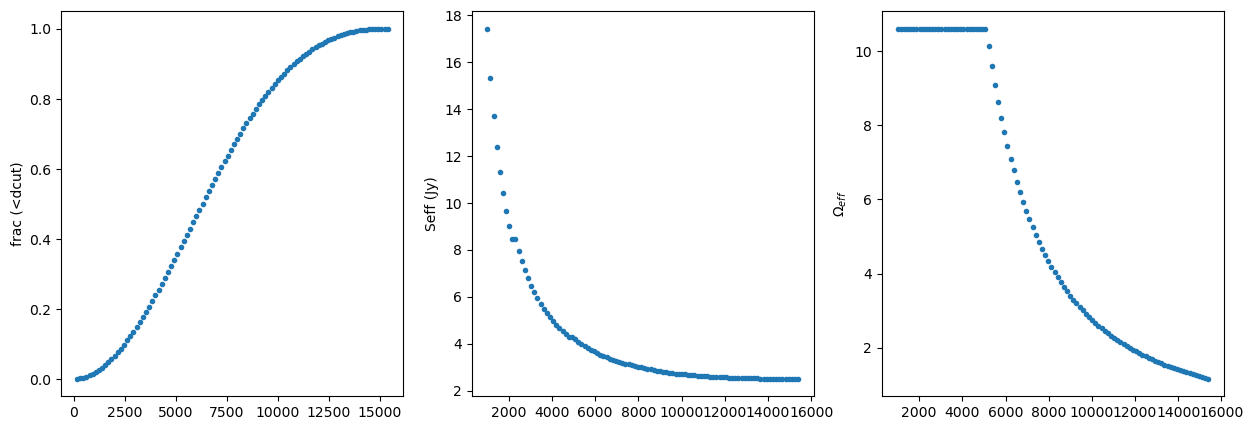

In [7]:
# reproducing Liam's plots

s0 = 2.5
nbeam_max = 1e6

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(minbl, blfrac, '.')
ax1.set_ylabel('frac (<dcut)')
arr = np.linspace(1000, max(minbl), 100)
ax2.plot(arr, [seff(dist, s0) for dist in arr], '.')
ax2.set_ylabel('Seff (Jy)')
ax3.plot(arr, [oeff(dist, nbeam_max) for dist in arr], '.')
ax3.set_ylabel('$\Omega_{eff}$')


In [8]:
# replace np.sqrt(1) with (np.sqrt(b/bref))
rch = lambda dist, alpha: 500*((1100/900)*oeff(dist, nbeam_max))**2/200 * ((50/seff(dist, s0))*np.sqrt(1))**(alpha)
rl = lambda dist, alpha: 60*((1100/1350)*oeff(dist, nbeam_max))**2/75 * ((75/seff(dist, s0))*np.sqrt(1))**(alpha)


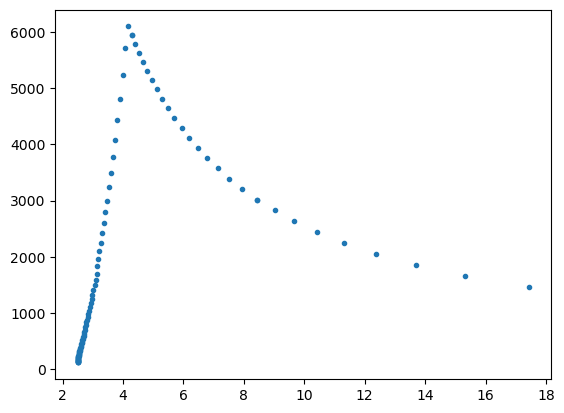

In [9]:
se = [seff(dist, s0) for dist in arr]
rtot = [rch(dist, 1.0)+rl(dist, 1.0) for dist in arr]

plt.plot(se, rtot, '.')

# Data products

1. Cadenced, all-sky survey images
 - 16 epoch, 10 subband, all-sky survey in Stokes I
 - 30940 deg2 (Dec>-30) area repeated every 4 months
 - With healpix, we require 2^18 sides with 0.81” resolution and 5.6e11 pixels across sky
 - 65% of on-sky time
2. Spectral line image cubes
 - Zoom A (redshifted HI) over 4096 channels (<1420.4 MHz, 8.4 kHz, Stokes I)
 - Zoom B (local HI/OH) over 2048 channels (1 kHz, Stokes IQUV)
 - Same spatial coverage as CASS, but stacked epochs
 - 65% of on-sky time
3. Polarimetry image cubes
 - 605 channels (2.15 MHz, Stokes QUV)
 - Same spatial coverage as CASS, but stacked epochs
 - 65% of on-sky time
4. GW follow-up imaging
 - CASS-like, but targeted and deeper
 - 10 deg2
 - 5% of on-sky time
5. Deep field imaging
 - 30 deg2 images to 100 nJy depth
 - 5% of on-sky time
6. Mid-tier imaging
 - Commensal with pulsar timing of known MSPs
 - 20% of on-sky time
7. Pulsar timing
 - Four, coherently dedispersed beams for all millisecond pulsars observed monthly
 - Stokes profiles sampled each 10 s over 30 min per target
 - Profile has 2048 phase bins across pulsar rotation (1.4 to 20 ms)
 - 20% of on-sky time
8. Pulsar search triggers
 - 1400 MSPs, 14000 CPs per sky per epoch
 - folded dynamic spectra, 2 bit, 100 microsec resolution over 10 sec, Stokes I, 9 beams, 2500 channels(for visualization/assessment)
 - 100% of on-sky time
9. Fast transient search triggers
 - Incoherent beam power for 20 seconds of 16384 channels, 0.8 ms sampling, 20 s (FRB search, Stokes I)
 - 100% of on-sky time
 - Voltage trigger of 100 ms, 4.4 Gsps, 4000 ant-pols (post-dedispersion)
 - Beam trigger of 9 beams, 100 microsec samples, 4 sec total, 2500 channels (for visualization/assessment)


### Data rates

In [10]:
# starting point
e_onsky = 0.85  # onsky efficiency (when operational)
e_observing = 0.95  # observing efficiency (fraction on target)

hrsperyr = 365.24 * 24
hrsperyr_onsky = hrsperyr*e_onsky

frac_cass = 0.65  # fraction of time observing cass
frac_deep = 0.05  # fraction of time observing deep fields
frac_gwf = 0.05  # fraction of time observing GW follow-up
frac_pta = 0.25  # fraction of time observing pulsar timing


In [11]:
# Given sensitivity/area, what is the cadence?
#s0 = 1.75e-6  # using Steve's mosaic strategy with 19.8min effective observing time. 8174 pointings
s0 = 2e-6
a0 = 30940
o0 = 1/e_observing
t_clock = 5
t_total = t_clock * 365.24 * 24 * e_onsky # 5 years in hrs with efficiency

hrs_cassepoch = surveytime('DSA', s0, a0, o0)
n_cassepoch = frac_cass*t_total/hrs_cassepoch
print(f'{hrs_cassepoch:.0f} hrs (incl cal) to cover {a0:.0f} sq deg to depth of {s0:.1e} Jy with {n_cassepoch:.1f} epochs in {t_clock} years. Survey speed: {a0/hrs_cassepoch:.1f} deg2/hr. ')

# 365.24 * 24 * e_onsky, t_total, t_epoch, t_epoch/(365.24 * 24 * e_onsky)

1590 hrs (incl cal) to cover 30940 sq deg to depth of 2.0e-06 Jy with 15.2 epochs in 5 years. Survey speed: 19.5 deg2/hr. 


In [12]:
# How big is all-sky image?
oversample = 4  # pixel/beam
bytesperpix = 4  # bytes per pixel (dynamic range requirement?)
dec_min = -30
#nside_thetab = find_hpnside(resolution(freq['DSA'], bmax['DSA'])/3600/oversample)
nside_thetab = find_hpnside(resolution(13e8, bmax['DSA'])/3600/oversample)
nside_thetap = find_hpnside(fov['DSA']/60)
n_pix_tot = int(np.round(healpy.nside2npix(nside_thetab)*(survey_area(dec_min)/survey_area(-90))))
thetab_resol = healpy.nside2resol(nside_thetab, arcmin=True)*60
print(f'Pixelate the sky with {n_pix_tot/1024**4} Tpixels of resolution {thetab_resol:.2f} arcsec (healpix nside={nside_thetab})')
print(f'\tThis requires {bytesperpix*n_pix_tot/1024**4} TB (Stokes I, one band)')

print(f'{nside_thetab//nside_thetap} pixels per pointing (thetab side length)')
print(f'{int(2*1.19*nside_thetab//nside_thetap)} pixels per pointing (first null side length)')

Pixelate the sky with 0.5625 Tpixels of resolution 0.81 arcsec (healpix nside=262144)
	This requires 2.25 TB (Stokes I, one band)
8192 pixels per pointing (thetab side length)
19496 pixels per pointing (first null side length)


In [13]:
# How many pointings to cover the sky?
n_pointings = int(np.round(healpy.nside2npix(nside_thetap)*(survey_area(dec_min)/survey_area(-90))))
ts = 4  # nside pointings/tile
n_tiles = int(np.round(healpy.nside2npix(nside_thetap//ts)*(survey_area(dec_min)/survey_area(-90))))
thetap_area = healpy.nside2pixarea(nside_thetap, degrees=True)
tile_area = healpy.nside2pixarea(nside_thetap//ts, degrees=True)
print(f'Cover the sky with {n_pointings} pointings ({thetap_area:.2f} deg^2) and {n_tiles} tiles ({tile_area:.2f} deg^2)')

print(healpy.nside2npix(nside_thetab)/healpy.nside2npix(nside_thetap))

Cover the sky with 9216 pointings (3.36 deg^2) and 576 tiles (53.71 deg^2)
67108864.0


### CASS data rates: DR1, DR2, DR3

In [14]:
# derived from DR3 post processing
# data rate is based on number of mosaicked pixels generated per year

nbands = 10
rate1 = bytesperpix*nbands*n_pix_tot/hrs_cassepoch/frac_cass  # all sky image per year in B/hr
print(f"{rate1/1e9:0.1f} GB/hr averaged over year (epoch {hrs_cassepoch:.1f} hr)")

23.9 GB/hr averaged over year (epoch 1590.3 hr)


In [15]:
# 5360, 134 kHz subbands, Stokes I
# 2048 ch, full-Stokes in zoom a
# 4096 ch, stokes I in zoom b
# data rate is based on number of mosaicked pixels generated in first epoch (later ones are accumulated)

rate2 = bytesperpix*(5360 + 2048 + 4096)*n_pix_tot/hrs_cassepoch
print(f"{rate2/1e9:0.1f} GB/hr per epoch ({hrs_cassepoch:.1f} hr)")

17896.2 GB/hr per epoch (1590.3 hr)


In [16]:
# 605, 2.15 MHz subbands, full-Stokes
# notes: 16k channels total of width 134 kHz.
# 9680 channels selected across 2.2 GHz sampled band.
# 605 servers sample from 1000 channels in range from 0-2.2 GHz.
# data rate is based on number of mosaicked pixels generated in first epoch (later ones are accumulated)

rate3 = bytesperpix*(4*605)*n_pix_tot/hrs_cassepoch
print(f"{rate3/1e9:0.1f} GB/hr per epoch ({hrs_cassepoch:.1f} hr)")

3764.7 GB/hr per epoch (1590.3 hr)


### GW follow-up rate: DR4

In [17]:
s0 = 1e-6
a0 = 10
o0 = 1/e_observing
hrs_gwepoch = surveytime('DSA', s0, a0, o0)
# fraction of time defines number of gw follow-up fields
n_gwepoch = (frac_gwf*hrsperyr_onsky)/hrs_gwepoch
print(f"{int(n_gwepoch)} GW follow-up observations of {hrs_gwepoch:.1f} hrs, {a0} deg2 to depth {s0} Jy")

181 GW follow-up observations of 2.1 hrs, 10 deg2 to depth 1e-06 Jy


In [18]:
npix_field = (nside_thetab//nside_thetap)**2

rate4 = nbands*n_gwepoch*bytesperpix*npix_field/hrsperyr_onsky
print(f"{rate4/1e9} GB/hr averaged over year for {int(n_gwepoch)} fields and {nbands} bands")

0.06528310711466313 GB/hr averaged over year for 181 fields and 10 bands


### Deep rate: DR5

In [19]:
# deep, wider field
s0 = 50e-9
a0 = 20
o0 = 1/e_observing
hrs_deepepoch = surveytime('DSA', s0, a0, o0)
# fraction of time defines number of gw follow-up fields
n_deepepoch = (frac_deep*hrsperyr_onsky)/hrs_deepepoch
print(f"{hrs_deepepoch:.1f} hrs ({n_deepepoch:.2f} of field per year) on deep field of {a0} deg2 to depth {s0} Jy")

npix_field = a0/thetap_area*(nside_thetab//nside_thetap)**2

rate5 = nbands*bytesperpix*npix_field/(frac_deep*hrsperyr_onsky)
print(f"{rate5/1e9:0.4f} GB/hr averaged over year with {nbands} bands")

1644.7 hrs (0.23 of field per year) on deep field of 20 deg2 to depth 5e-08 Jy
0.0429 GB/hr averaged over year with 10 bands


### Mid rate: DR6

In [20]:
# commensal imaging on PTA
hrs_ptaepoch = frac_pta*hrsperyr_onsky
n_pta = 200
npix_field = (nside_thetab//nside_thetap)**2

rate6 = nbands*bytesperpix*npix_field*n_pta/hrsperyr_onsky
print(f"{rate6/1e9} GB/hr averaged over year with {nbands} bands on {n_pta} targets.")

0.07205454377567476 GB/hr averaged over year with 10 bands on 200 targets.


### PTA rate: DR7

In [21]:
# Stokes profile assumptions
# 1 sec resolution over 30 min
# 2048 phase bins across 1.4 and ~20 ms
# 2.048 MHz channels across 1.3 GHz band
# 4 stokes parameters
# 1 of four beams used on average
# 32b floats
# 200 targets with 1 month cadence
# total data: [phase]*[freq]*[time]*[pol]*[beam]

bytes_ptasample = 1*4*4*2048*(1300/2.048)  # a sample size
rate7 = bytes_ptasample * hrs_ptaepoch/(1/3600)/hrsperyr_onsky
print(f"{rate7/1e9:.1f} GB/hr averaged over year for {hrs_ptaepoch:.1f} hrs. ({bytes_ptasample*1800/1e9:.1f} GB per 30min session)")

18.7 GB/hr averaged over year for 1862.7 hrs. (37.4 GB per 30min session)


### Periodicity search rate: DR8

In [22]:
# per source: 9 beams, 4B, full stokes, 100 microsec samples, 4 sec total, 2500 channels
bytes_psrsample = 4*9*4*(4/0.1)*2500
npsr = 1400+14000  # from Myles, per CASS epoch
rate8 = bytes_psrsample*npsr/hrs_cassepoch/frac_cass  # assume most sources found in CASS
print(f"{rate8/1e9:.1f} GB/hr averaged over year for {npsr} PSR detections during CASS")

0.2 GB/hr averaged over year for 15400 PSR detections during CASS


### Single-pulse search rate: DR9

In [23]:
# power trigger per source: 9 beams, 4B, full stokes, 100 microsec samples, 4 sec total, 2500 channels
# voltage trigger per source: 4000 ants, 4.4 Gsps, 100 msec (dedispersed cutout)

nfrb = 2000  # Liam estimates range of 800-4000/yr
bytes_voltagesample = 4.4e9 * 4000 * 1e-1

rate9 = nfrb*(bytes_psrsample + bytes_voltagesample)/hrs_cassepoch/frac_cass
rate9b = nfrb*(2*bytes_psrsample)/hrs_cassepoch/frac_cass
print(f"{rate9/1e9:.1f} GB/hr averaged over year for {nfrb} FRB detections during CASS ({rate9b/1e9:.1e} GB/hr after processing). Power triggers are {bytes_psrsample/bytes_voltagesample:.1e} fraction of voltage trigger")


3405.4 GB/hr averaged over year for 2000 FRB detections during CASS (5.6e-02 GB/hr after processing). Power triggers are 8.2e-06 fraction of voltage trigger


### Summary

In [24]:
rates = [rate1, rate2, rate3, rate4, rate5, rate6, rate7, rate8, rate9]
over = 5  # raw image size relative to post-processing size

print("raw GB/hr over year 1:")
print(f"2: {over*rate2/1e9:.1e}, 3: {over*rate3/1e9:.1e}, 4: {over*rate4/1e9:.1e}, 5: {over*rate5/1e9:.1e}, 6: {over*rate6/1e9:.1e}, 7: {rate7/1e9:.1e}, 8: {rate8/1e9:.1e}, 9: {rate9/1e9:.1e}") 
print("Post-processing GB/hr over year 1:")
print(f"1: {rate1/1e9:.1e}, 2: {rate2/1e9:.1e}, 3: {rate3/1e9:.1e}, 4: {rate4/1e9:.1e}, 5: {rate5/1e9:.1e}, 6: {rate6/1e9:.1e}, 7: {rate7/1e9:.1e}, 8: {rate8/1e9:.1e}, 9: {rate9b/1e9:.1e}") 

print("raw GB/hr over years 2 through 5:")
print(f"1: {rate3/4/1e9:.1e}, 4: {rate4/1e9:.1e}, 5: {rate5/1e9:.1e}, 6: {rate6/1e9:.1e}, 7: {rate7/1e9:.1e}, 8: {rate8/1e9:.1e}, 9: {rate9/1e9:.1e}") 
print("Post-processing GB/hr over years 2 through 5 potentially moved off site:")
print(f"1: {rate1/1e9:.1e}, 4: {rate4/1e9:.1e}, 5: {rate5/1e9:.1e}, 6: {rate6/1e9:.1e}, 7: {rate7/1e9:.1e}, 8: {rate8/1e9:.1e}, 9: {rate9b/1e9:.1e}") 

raw GB/hr over year 1:
2: 8.9e+04, 3: 1.9e+04, 4: 3.3e-01, 5: 2.1e-01, 6: 3.6e-01, 7: 1.9e+01, 8: 2.1e-01, 9: 3.4e+03
Post-processing GB/hr over year 1:
1: 2.4e+01, 2: 1.8e+04, 3: 3.8e+03, 4: 6.5e-02, 5: 4.3e-02, 6: 7.2e-02, 7: 1.9e+01, 8: 2.1e-01, 9: 5.6e-02
raw GB/hr over years 2 through 5:
1: 9.4e+02, 4: 6.5e-02, 5: 4.3e-02, 6: 7.2e-02, 7: 1.9e+01, 8: 2.1e-01, 9: 3.4e+03
Post-processing GB/hr over years 2 through 5 potentially moved off site:
1: 2.4e+01, 4: 6.5e-02, 5: 4.3e-02, 6: 7.2e-02, 7: 1.9e+01, 8: 2.1e-01, 9: 5.6e-02


In [25]:
sum1_raw = sum([over*rate1*hrsperyr_onsky, over*(rate2+rate3)*hrsperyr_onsky*frac_cass, over*rate4*hrsperyr_onsky, over*rate5*hrsperyr_onsky, over*rate6*hrsperyr_onsky, rate7*hrsperyr_onsky, rate8*hrsperyr_onsky, rate9*hrsperyr_onsky])/1e15

sum1_post = sum([rate1*hrsperyr_onsky, (rate2+rate3)*hrs_cassepoch, rate4*hrsperyr_onsky, rate5*hrsperyr_onsky, rate6*hrsperyr_onsky, rate7*hrsperyr_onsky, rate8*hrsperyr_onsky, rate9b*hrsperyr_onsky])/1e15

sum25_post = sum([rate1*hrsperyr_onsky, rate4*hrsperyr_onsky, rate5*hrsperyr_onsky, rate6*hrsperyr_onsky, rate7*hrsperyr_onsky, rate8*hrsperyr_onsky, rate9b*hrsperyr_onsky])/1e12

print(f"{sum1_raw:.1f} PB raw each year")
print(f"Post-processing of {sum1_post:.2f} PB in yr 1.")
print(f"raw rate23: {over*(rate2+rate3)*hrsperyr_onsky*frac_cass/1e15:.1f}")
print(f"raw rate9: {rate9*hrsperyr_onsky/1e15:.1f}")
print(f"rate1: {rate1*hrsperyr_onsky/1e12:.1f}")
print(f"rate7: {rate7*hrsperyr_onsky/1e12:.1f}")
print(f"Post-processing of {sum25_post:.1f} TB/yr in yrs 2-5 ({1e3*sum25_post*8/(365.24*24*3600):.2f} Gb/s moving off site).")

550.9 PB raw each year
Post-processing of 34.77 PB in yr 1.
raw rate23: 524.5
raw rate9: 25.4
rate1: 178.3
rate7: 139.5
Post-processing of 321.2 TB/yr in yrs 2-5 (0.08 Gb/s moving off site).


# And now for something completely different (PDR)

## Field and tile image calculations for RCP and DAT storage

In [26]:
imlen = 2**14
imsize = bytesperpix*imlen**2

print(f'{imsize/1e9:.1f} GB per field image (per pol-chan)')

1.1 GB per field image (per pol-chan)


In [34]:
# channels
n_za = 960
n_zb = 4192
n_nl = 5600 # 5492
n_mp = 500*4 # 625*4
n_wc = 10
n_fc = 1
n_totrcp = n_za+n_zb+n_nl+n_mp
n_totdat = n_za+n_zb+n_nl+n_mp+n_wc+n_fc
print(f'{n_totdat} pol-chan field images output by DAT. {n_totrcp} by RCP.')

12763 pol-chan field images output by DAT. 12752 by RCP.


In [35]:
# from Steve Myers Survey Implementation Plan (18 Oct 2023)
n_fields = 8594  # cover 30940 sq deg
n_tile = 341  # cover fields as roughly 5x5. 4.3 hrs on sky per tile
t_field = 10.3*60 # seconds of on-sky time per field

In [36]:
# total field data rate (into on-RCP distributed storage)
ngbs_dat = (n_totrcp * imsize / t_field) / 1e9

print(f'{ngbs_dat:.1f} GB/s output by RCP total (assuming continual observing)')

22.2 GB/s output by RCP total (assuming continual observing)


## On-RCP storage for field images


In [30]:
n_gpu = 10  # gpus per server
n_rcpl = 5  # output channels per GPU. 16 pol-chans (130 kHz) in and 4 (I; 130 kHz) plus 1 (IQUV; 2 MHz = 16x130 kHz) out
n_rcph = 1  # output channels per GPU. 16 pol-chans (130 kHz) in and 1 (IQUV; 2 MHz) out
n_rcpz = 4  # output channels per GPU. 16 pol-chans (130 kHz) in and 4 (I; 130 kHz) out

ntb_rcpl = n_rcpl*n_gpu * imsize / 1e12 / t_field * (0.8 * 24*3600*3)  # TB for 3 days of fields with 80% on-sky time
ntb_rcph = n_rcph*n_gpu * imsize / 1e12 / t_field * (0.8 * 24*3600*3)
ntb_rcpz = n_rcpz*n_gpu * imsize / 1e12 / t_field * (0.8 * 24*3600*3)

print(f'3-day on-RCP field storage per server (TB): {ntb_rcpl:.1f} RCP-L, {ntb_rcph:.1f} RCP-H, {ntb_rcpz:.1f} RCP-Z (for 80% on-target efficiency)')

3-day on-RCP field storage per server (TB): 18.0 RCP-L, 3.6 RCP-H, 14.4 RCP-Z (for 80% on-target efficiency)


## Mosaic and comparess to reduce I/O to centralized storage system

Full stacks and one-epoch mosaics kept there

Note: all fields kept in distributed storage on RCP until used for all mosaics. Mosaics written out for minimal area (no 1.8x inflation for edges)

In [31]:
f_mos = 2.93 # from the SIP (reduction factor for mosaic over pointings, but keeping mosaic edges)
f_comp = 2  # reduction factor for compression (e.g., from bitshuffle test and paper)

In [40]:
# scale from GB/s out of RCP to notional epoch of 4 months in DAT
npb_4months = ngbs_dat * (0.8*24*3600*30.4*4) / f_mos / f_comp / 1e6
ngbs_datout = ngbs_dat / f_mos / f_comp

print(f'{ngbs_datout:.1f} GB/s mosaic output by DAT. {npb_4months:.1f} PB of storage for 4 month epoch of all mosaics')

3.8 GB/s mosaic output by DAT. 31.8 PB of storage for 4 month epoch of all mosaics


## Stacks

In [33]:
npb_dat_stack = n_totdat*bytesperpix*n_pix_tot/f_comp/1024**5
  
print(f'Cover sky with {n_pix_tot/1e12:.2f} Terapixels of {bytesperpix*n_pix_tot/1024**4} TB per pol-chan and {npb_dat_stack:.1f} PB total')

Cover sky with 0.62 Terapixels of 2.25 TB per pol-chan and 14.5 PB total


In [45]:
print(f'{npb_4months + npb_dat_stack:.1f} PB total centralizd storage')

46.2 PB total centralizd storage
